In [2]:
import os
import pickle
import pandas as pd

classifiers = ["EDC", "random_forest", "logistic_regression", "svm_linear", "svm_rbf", "decision_tree"]
score_metric = "auc_score"
score_metric_index = 0 if score_metric == "auc_score" else 1

result_files = os.listdir("results")
results = []
for result_file in result_files:
    dataset, search_strategy, optimiser, random_seed = result_file.split(
        "."
    )[0].split("-")
    with open(f"results/{result_file}", "rb") as f:
        res = pickle.load(f)
    for elapsed_time, auc_score, accuracy_score in zip(res["elapsed_time"], res["auc_score"], res["accuracy_score"]):
        results.append(
            [
                dataset,
                "EDC",  # "classifier
                search_strategy,
                optimiser,
                elapsed_time,
                auc_score,
                accuracy_score,
                random_seed,
            ]
        )

result_files = os.listdir("comparison_results")
for result_file in result_files:
    dataset, classifier, random_seed = result_file.split(
        "."
    )[0].split("-")
    with open(f"comparison_results/{result_file}", "rb") as f:
        res = pickle.load(f)
    for elapsed_time, auc_score, accuracy_score in zip(res["elapsed_time"], res["auc_score"], res["accuracy_score"]):
        results.append(
            [
                dataset,
                classifier,  # "classifier
                None,
                None,
                elapsed_time,
                auc_score,
                accuracy_score,
                random_seed,
            ]
        )


df = pd.DataFrame(
    columns=[
        "dataset",
        "classifier",
        "search_strategy",
        "optimiser",
        "elapsed_time",
        "auc_score",
        "accuracy_score",
        "random_seed"
    ],
    data=results,
)

In [3]:
# Only select specific datasets
datasets = [
    "ADULT",
    "BANKNOTE",
    "BREAST",
    "CREDIT",
    "CYLINDER",
    "DIABETES",
    "HEPATITIS",
    "IONOSPHERE",
    "OCCUPANCY",
    "SONAR",
    "WISCONSIN",
]

df = df[df["dataset"].isin(datasets)]

In [4]:
grouped = df.groupby(["dataset", "classifier"])

classifier_name_map = {
    "EDC": "EDC",
    "random_forest": "RF",
    "logistic_regression": "LR",
    "svm_linear": "SVM (linear)",
    "svm_rbf": "SVM (rbf)",
    "decision_tree": "Tree",
}
classifiers = ["EDC", "random_forest", "logistic_regression", "svm_linear", "svm_rbf", "decision_tree"]
data_dict = {d: [0] * len(datasets) for d in classifier_name_map.values()}
for name, group in grouped:
    data_dict[classifier_name_map[name[1]]][datasets.index(name[0])] = group["auc_score"].mean()
    # print(f"{name[0]} - {name[1]} - {group['auc_score'].mean()} - {len(group)}")

data = pd.DataFrame(data_dict).rename_axis("dataset").melt(
      var_name='classifier',
      value_name='score',
      ignore_index=False,
  ).reset_index()
print(data)


    dataset classifier     score
0         0        EDC  0.880033
1         1        EDC  0.999761
2         2        EDC  0.631462
3         3        EDC  0.917628
4         4        EDC  0.732428
..      ...        ...       ...
61        6       Tree  0.580688
62        7       Tree  0.885634
63        8       Tree  0.981968
64        9       Tree  0.769369
65       10       Tree  0.532100

[66 rows x 3 columns]


In [5]:
avg_rank = data.groupby('dataset').score.rank(ascending=False, pct=False).groupby(data.classifier).mean()
print(avg_rank)

classifier
EDC             3.181818
LR              4.181818
RF              1.636364
SVM (linear)    4.000000
SVM (rbf)       3.090909
Tree            4.909091
Name: score, dtype: float64


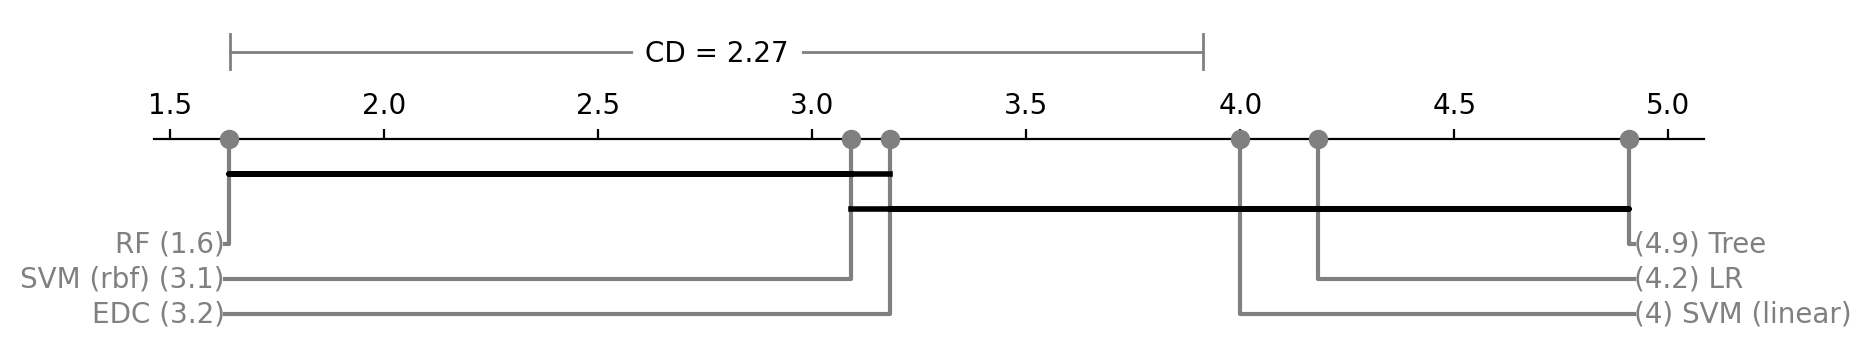

In [7]:
import matplotlib.pyplot as plt
import scikit_posthocs as sp

test_results = sp.posthoc_nemenyi_friedman(
    data,
    melted=True,
    block_col='dataset',
    group_col='classifier',
    y_col='score',
)


fig, ax = plt.subplots(
    1, 1, figsize=(10, 2), dpi=200

)
# plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(
    avg_rank, test_results,
    ax=ax,
    elbow_props={'color': 'gray'}
)

critical_distance = 2.2735
start = 1.64

ax.add_line(plt.Line2D(
    [start, start], [2, 3],
    color='gray', linewidth=1, linestyle='-'
))

ax.add_line(plt.Line2D(
    [start, start + critical_distance], [2.5, 2.5],

    color='gray', linewidth=1, linestyle='-'
))

text = ax.text(
    start + critical_distance / 2, 2.2, f'CD = {critical_distance:.2f}',
    horizontalalignment='center',
)
text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax.add_line(plt.Line2D(
    [start + critical_distance, start + critical_distance], [2, 3],
    color='gray', linewidth=1, linestyle='-'
))

plt.show()